In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import moveaxis
import time
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from sklearn.preprocessing import StandardScaler
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import rasterio as rio
from rasterio.plot import show, plotting_extent

In [4]:
# Load interpolated test data
test_ = np.load("interpolatedStudyRegionNew.npy")
# test_ = test_.astype(np.float32)

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device="cpu"

In [6]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length
        
        self.batchNorm = nn.BatchNorm1d(seq_length)
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
#         self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
        self.fc = nn.Linear(hidden_size,num_classes)
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).requires_grad_().to(device) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).requires_grad_().to(device) #internal state
        # Propagate input through LSTM
        norm = self.batchNorm(x)
#         print(norm)
        output, (hn, cn) = self.lstm(norm, (h_0, c_0)) #lstm with input, hidden, and internal state
#         out,_ = torch.max(output,dim=1)
        out = self.fc(output[:,-1,:])
#         hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
#         out = self.relu(hn)
#         out = self.fc_1(out) #first Dense
#         out = self.relu(out) #relu
#         out = self.fc(out) #Final Output
        return out

In [7]:
seq_len = 222
num_epochs = 80 #3 epochs
learning_rate = 0.001 #0.001 lr

input_size = 3 #number of features
hidden_size = 100 #number of features in hidden state
num_layers = 2 #number of stacked lstm layers

num_classes = 9 #number of output classes 

In [8]:
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers,seq_len)
lstm1.to(device)#our lstm class 
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(lstm1.parameters(), lr=learning_rate,momentum=0.9)

In [9]:
# Load trained model state weights
lstm1.load_state_dict(torch.load('StudyRegionModel.pth'))
lstm1.eval()

LSTM1(
  (batchNorm): BatchNorm1d(222, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm): LSTM(3, 100, num_layers=2, batch_first=True)
  (fc_1): Linear(in_features=100, out_features=128, bias=True)
  (relu): ReLU()
  (fc): Linear(in_features=100, out_features=9, bias=True)
)

In [10]:
# Generate predictions
t1 = time.time()
# Create an empty array of image size
predictions = np.zeros((test_.shape[0],test_.shape[1]),dtype=np.float32)
# Looping though every row
for i in tqdm(range(len(test_))):
    X_test_tensors = Variable(torch.Tensor(test_[i]))
    X_test_tensors_final = X_test_tensors.transpose(1,2).to(device)
    with torch.no_grad():
        outputs = lstm1(X_test_tensors_final)
        _,predicted = torch.max(outputs.data,1)
        predicted_numpy = predicted.cpu().numpy().squeeze()
        predictions[i,:] = predicted_numpy
predictions = predictions.astype('int16')
print("Took:",time.time()-t1)

100%|█████████████████████████████████████| 12823/12823 [36:40<00:00,  5.83it/s]


Took: 2200.742577314377


In [19]:
# Inverse transform the labels from label encoded to original
actualPredictions = predictions.flatten()
dataset = pd.read_pickle("StudyRegionTraining.pkl")
le = LabelEncoder()
dataset['class'] = le.fit_transform(dataset['class'])
actualPredictions = le.inverse_transform(actualPredictions)
actualPredictions = np.reshape(actualPredictions,(predictions.shape[0],predictions.shape[1]))

In [21]:
# Create a profile of image and transfer the predictions to the image
sample_b02 = rio.open('final_img_master/S1A_IW_GRDH_1SDV_20180715.tif') 
# outTIF = os.path.join("predicted_tif")
sample_b02_meta = sample_b02.profile 
with rio.open("studyRegionPredictionMaster.tif", 'w', **sample_b02_meta) as dst:
    dst.write(actualPredictions, 1)

In [22]:
predictions_loader = rio.open('studyRegionPredictionMaster.tif')

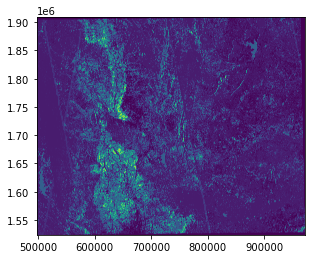

<AxesSubplot:>

In [23]:
show(predictions_loader)

In [24]:
np.unique(predictions_loader.read(1),return_counts=True)

(array([ 1,  2,  3,  5,  6, 11, 12, 13, 14], dtype=int16),
 array([ 43970816, 126308282,   3059303,   4167036,  10022601,  10876586,
          2460253,   1686701,     51822]))

In [20]:
np.unique(actualPredictions,return_counts=True)

(array([ 1,  2,  3,  5,  6, 11, 12, 13, 14]),
 array([ 43970816, 126308282,   3059303,   4167036,  10022601,  10876586,
          2460253,   1686701,     51822]))